In [11]:
import imblearn
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# 1.Load the dataset and explore the variables.

In [2]:
data = pd.read_csv(r'C:\Users\parag\Desktop\ironhack\lab\week8\lab-imbalanced-data\files_for_lab\customer_churn.csv') # this file is in files_for_lesson_and_activities folder
data#.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [3]:
data.shape

(7043, 21)

In [4]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


# 2. We will try to predict variable Churn using a logistic regression on variables tenure, SeniorCitizen,MonthlyCharges.

In [5]:
#data did not have  null value 
nulls = pd.DataFrame(data.isna().sum()*100/len(data), columns=['percentage'])
nulls.sort_values('percentage', ascending = False)

,percentage
customerID,0.0
DeviceProtection,0.0
TotalCharges,0.0
MonthlyCharges,0.0
PaymentMethod,0.0
PaperlessBilling,0.0
Contract,0.0
StreamingMovies,0.0
StreamingTV,0.0
TechSupport,0.0


In [6]:
data= data[[ 'SeniorCitizen','tenure','MonthlyCharges','Churn']]
data.head()

,SeniorCitizen,tenure,MonthlyCharges,Churn
0,0,1,29.85,No
1,0,34,56.95,No
2,0,2,53.85,Yes
3,0,45,42.30,No
4,0,2,70.70,Yes


# EDA

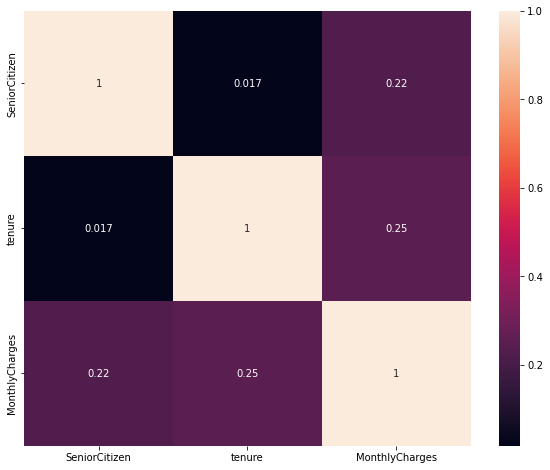

In [8]:
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

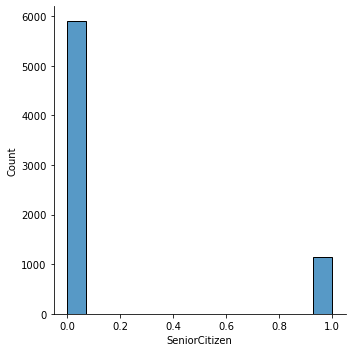

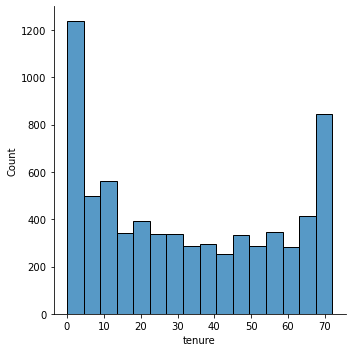

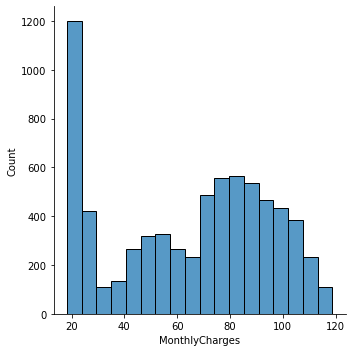

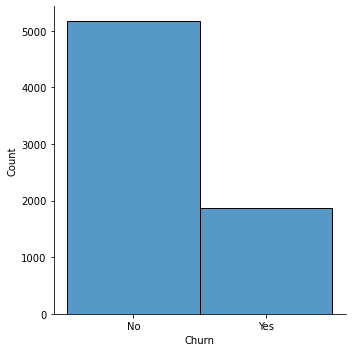

In [7]:
for col in data:
    sns.displot(data[col])
    plt.show()

# 3. Extract the target variable.

In [9]:
data['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

# 4.Extract the independent variables and scale them
# 5.Build the logistic regression model.
# 6.Evaluate the model.

### model benchmark

In [15]:
X = pd.get_dummies(data.drop('Churn', axis=1))
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_train, y_train)

predictions = classification.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          No       0.82      0.90      0.86      1035
         Yes       0.63      0.45      0.53       374

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.69      1409
weighted avg       0.77      0.78      0.77      1409



### Prediction after using normalizer

In [14]:
scaler = Normalizer()

X = pd.get_dummies(data.drop('Churn', axis=1))
X_scaled = scaler.fit_transform(X)
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

classification = LogisticRegression(random_state=42, max_iter=100000)
classification.fit(X_train, y_train)

predictions = classification.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          No       0.82      0.87      0.85      1035
         Yes       0.58      0.49      0.53       374

    accuracy                           0.77      1409
   macro avg       0.70      0.68      0.69      1409
weighted avg       0.76      0.77      0.76      1409



# Even a simple model will give us more than 70% accuracy. Why?

###  "No" proportio is higer than yes. This dataset of having imbalanced data

# Synthetic Minority Oversampling TEchnique (SMOTE)

In [21]:
from imblearn.over_sampling import SMOTE

In [23]:
smote = SMOTE()

X = data.drop('Churn', axis=1)

X_sm, y_sm = smote.fit_resample(X, y)
y_sm.value_counts()

No     5174
Yes    5174
Name: Churn, dtype: int64

In [25]:
X = pd.get_dummies(data.drop('Churn', axis=1))
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, y_train = smote.fit_resample(X_train, y_train)

classification = LogisticRegression(random_state=42, max_iter=100000)
classification.fit(X_train, y_train)

predictions = classification.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          No       0.87      0.72      0.79      1035
         Yes       0.48      0.71      0.57       374

    accuracy                           0.72      1409
   macro avg       0.68      0.72      0.68      1409
weighted avg       0.77      0.72      0.73      1409



# Tomek links

In [27]:
from imblearn.under_sampling import TomekLinks

In [28]:
X = data.drop('Churn', axis=1)
y = data['Churn']

tomek = TomekLinks()
X_tl, y_tl = tomek.fit_resample(X, y)
y_tl.value_counts()

No     4712
Yes    1869
Name: Churn, dtype: int64

In [32]:
X = pd.get_dummies(data.drop('Churn', axis=1)).reset_index()
y = data['Churn']

X_, y_ = tomek.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42, stratify=y_)

classification = LogisticRegression(random_state=42, max_iter=100000)
classification.fit(X_train, y_train)

predictions = classification.predict(X_test)
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

          No       0.83      0.89      0.86       910
         Yes       0.67      0.57      0.62       374

    accuracy                           0.79      1284
   macro avg       0.75      0.73      0.74      1284
weighted avg       0.79      0.79      0.79      1284

